In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# Import libraries
import pandas as pd
import churn.config as cfg
from ydata_profiling import ProfileReport
from churn.paths import create_directories, DATA_DIR
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from churn.preprocessing import load_data

from churn.plot import plot_barcharts, plot_boxplots
from sklearn.pipeline import make_pipeline
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns
from pathlib import Path
from churn.analytics import (
    cramers_v_for_unique_pairs, 
    correlation_matrix, 
    relationships_cat_vs_num, 
    calculate_cramers_v, 
    analyze_features, 
    print_best_results, 
    fit_best_discretizers, 
    create_binned_dataset,
    compare_variances
)
%matplotlib inline

2024-08-30 12:31:36,693 - INFO - Pandas backend loaded 2.2.2
2024-08-30 12:31:36,697 - INFO - Numpy backend loaded 1.26.4
2024-08-30 12:31:36,697 - INFO - Pyspark backend NOT loaded
2024-08-30 12:31:36,697 - INFO - Python backend loaded


In [4]:
# Path to the raw data
create_directories()
file_path = Path(DATA_DIR / 'churn.parquet')

2024-08-30 12:31:38,019 - INFO - Folder "data" ensured at "/Users/borja/Documents/Somniumrema/projects/ml/churn/data"


In [5]:
# Load the raw data
raw = load_data(file_path) 
# Display the first rows of the raw data
raw.head()

2024-08-30 12:31:38,112 - INFO - Data loaded from /Users/borja/Documents/Somniumrema/projects/ml/churn/data/churn.parquet


,area_code,plan,n_sms,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,customer_service_calls,customer_service_rating,customer_hapiness,churn
237522,5.0,2.0,724,1365.991021,203,50.449691,681.643301,140,33.122690,157.639198,53,25.163988,14,8,0.298234,0
847276,2.0,3.0,387,1253.394397,158,77.050620,437.941533,88,20.629900,220.159029,32,58.178678,0,8,0.424740,0
242450,8.0,1.0,490,627.687099,165,42.508170,618.231970,54,17.826781,178.298004,85,47.785126,32,5,0.378805,1
377221,3.0,1.0,822,601.816333,115,72.020707,605.255759,106,27.550356,212.695526,30,6.765252,25,9,0.175085,0
991506,1.0,2.0,455,951.019715,140,44.885685,320.538743,75,25.209541,217.364011,98,25.802669,36,6,0.612607,0


In [6]:
# Generate profile report
profile = ProfileReport(raw, title="Churn Dataset Report")
profile.to_file("churn_dataset_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# Rename column 'customer_hapiness' and apply the correct type to the variables
raw = (raw
       .rename(columns={'customer_hapiness': 'customer_happiness'})
       .assign(
    area_code=lambda df: df['area_code'].astype('category'),
    plan=lambda df: df['plan'].astype('category'),
    churn=lambda df: df['churn'].astype('category'))
)

## Dividir los datos de partida en dos muestras entrenamiento y test
 -  Semilla: 123
 - Split para la muestra de test: 25%
 - División estratificada

In [8]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    raw.drop(columns='churn'), 
    raw['churn'], 
    test_size=cfg.TEST_SIZE, 
    random_state=cfg.SEED, 
    stratify=raw['churn']
)

In [9]:
# Combine X_train and y_train for further analysis
train_data = X_train.copy()
train_data['churn'] = y_train.values

# Combine X_test and y_test for future use
test_data = X_test.copy()
test_data['churn'] = y_test.values

# Show the shapes of the resulting splits
train_data.shape, test_data.shape

((5625, 16), (1875, 16))

In [10]:
# Identify numeric variables
numeric_data_train = train_data.select_dtypes(include=[np.number])
# Identify categorical variables
categorical_data_train = train_data.select_dtypes(include=['category'])

## Preprocesado:

a) Estudiar la posible multicolinealidad entre las variables predictoras usando la correlación de Pearson

2024-08-30 12:31:53,178 - INFO - Correlation matrix calculated using method: pearson


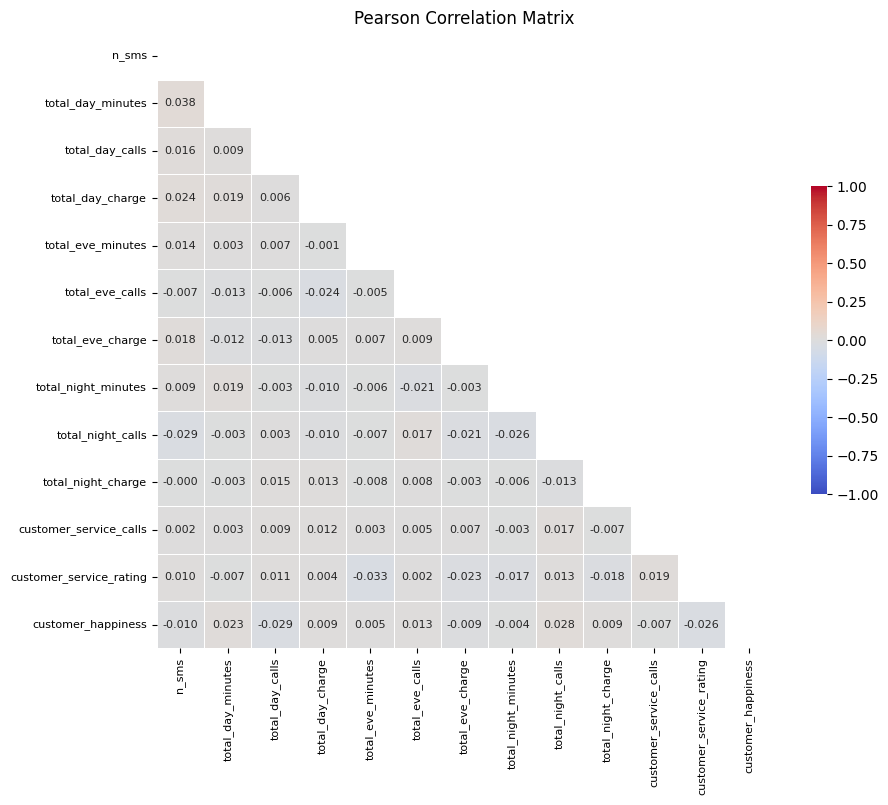

In [11]:
# Plot the correlation matrix of numeric variables
correlation_matrix(numeric_data_train, 'pearson', cfg.FIG_SIZE,'coolwarm', True, '.3f', 8, False)   

In [12]:
# Calculate the Cramer's V for unique pairs of categorical variables
cramer_v_categorical = cramers_v_for_unique_pairs(train_data)
    
# Show results
cramer_v_categorical

2024-08-30 12:31:53,717 - INFO - Categorical columns: Index(['area_code', 'plan', 'churn'], dtype='object')


{'area_code_vs_plan': 0.0, 'area_code_vs_churn': 0.0, 'plan_vs_churn': 0.0}

In [13]:
# Gráficos de barras para las variables categóricas vs la variable objetivo

In [14]:
# Identify relationships between categorical and numeric variables
test_results_df = relationships_cat_vs_num(train_data, categorical_data_train, numeric_data_train)

# Filter the DataFrame to only show significant relationships
significant_results_df = test_results_df[test_results_df['P-Value'] < 0.05]

# Show results
significant_results_df

,Categorical Variable,Numerical Variable,Test Used,P-Value
22,plan,total_night_charge,Kruskal-Wallis,4.252901e-02
36,churn,customer_service_calls,Kruskal-Wallis,4.717166e-215
37,churn,customer_service_rating,Kruskal-Wallis,1.067591e-21
38,churn,customer_happiness,Kruskal-Wallis,7.862490e-59


In [15]:
# Gráficos de las variables numéricas vs la variable objetivo

b) Analizar de forma gráfica la distribución de las variables predictoras frente a la target (tanto numéricas como categóricas)

In [16]:
numeric_data_train.columns


Index(['n_sms', 'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'customer_service_calls', 'customer_service_rating',
       'customer_happiness'],
      dtype='object')

## Corregir los ejes para que indiquen lo que representan

In [17]:
# Plot boxplots for numeric variables vs the target variable
plot_boxplots(train_data, numeric_data_train)

In [18]:
# Select categorical variables (including customer_service_rating) to plot
variables_to_plot = train_data[['area_code','plan','customer_service_rating']]

# Plor barcharts
plot_barcharts(train_data, variables_to_plot, 'churn')

Selección de características: entrenar un modelo random forest y escoger las 7 variables más importantes para el modelo

 Haz un entrenamiento simple con los siguientes hiperámetros:
● número estimadores: 50
● máxima profundidad del árbol: 6
● semilla: 123

In [19]:
# Instantiate Random Forest model with the specified hyperparameters
rf_model = RandomForestClassifier(n_estimators=cfg.ESTIMATORS,
                                  max_depth=cfg.DEPTH,
                                  random_state=cfg.SEED
                                  )

# Train the model
rf_model.fit(X_train, y_train)

# Obtain feature importances from the model
importances = rf_model.feature_importances_

# Sort the feature importances in descending order and select only the top 7
indices = np.argsort(importances)[-cfg.NUM_FEATURES:] 

# Select the features corresponding to the top 7 importances
features = X_train.columns[indices]

# Print the top 7 features
features

Index(['total_day_minutes', 'n_sms', 'total_eve_minutes', 'total_eve_calls',
       'customer_service_rating', 'customer_happiness',
       'customer_service_calls'],
      dtype='object')

In [20]:
# Graph showing the feature importance of the top 7 features
fig = px.bar(
    x=importances[indices],
    y=features,
    orientation='h',
    labels={'x': 'Feature Importance', 'y': 'Features'},
    color_discrete_sequence=['cornflowerblue']  # Set bar color to blue
)

# Update layout to make the chart smaller and set black background
fig.update_layout(
    height=400, 
    width=900, 
    title_text='Feature Importance (Random Forest)',
    **cfg.PLOTLY_LAYOUT_CONFIG
)

# Plot the graph
fig.show()

Categorizar todas las variables predictoras.
■ Cada variable debe contener, al menos, 4 niveles
■ Utiliza cualquier técnica que consideres adecuada para tramear las variables numéricas (cuantiles, juicio experto, information-value)
Estudiar el grado de asociación entre las variables predictoras (y frente al target). Puedes emplear la chi-square del paquete (spicy, R-básico) o la V-Cramer, su generalización.
Ten en cuenta que el preprocesado debe hacerse, inicialmente, sobre la muestra de entrenamiento. Una vez definidos los niveles de las variables propuestas, estos deben ser también planteados en la muestra de test.

In [21]:
train_features = X_train[features].copy()
train_features['churn'] = y_train.values

test_features = X_test[features].copy()
test_features['churn'] = y_test.values

In [22]:
train_features

,total_day_minutes,n_sms,total_eve_minutes,total_eve_calls,customer_service_rating,customer_happiness,customer_service_calls,churn
497788,395.376575,221,607.641676,61,9,0.183441,0,0
69163,782.477667,179,609.519649,144,3,0.010195,0,0
346342,1144.482697,218,549.213721,183,8,0.710498,0,0
59207,1147.911848,502,559.978057,163,10,0.040356,51,1
682551,941.033109,229,438.069271,99,10,0.260329,19,0
...,...,...,...,...,...,...,...,...
914712,908.619791,86,405.317310,93,9,0.250214,0,0
559243,606.170931,194,987.233251,171,5,0.949713,0,0
77144,583.781503,332,640.828375,84,8,0.448140,13,0
191612,1336.114596,341,713.007138,217,9,0.003229,0,1


In [23]:
# # Transform into categorical the variable 'customer_service_rating'
# train_features['customer_service_rating'] = train_features['customer_service_rating'].astype('category')

# # Calculate the Cramer's V for the new categorical feature against churn
# cramers_v_for_unique_pairs(train_features)

In [24]:
# Create a copy of the training features
train_features = train_features.copy()

# Establish the bin range from 4 to 50
bin_range = cfg.BIN_SIZES

# Establish the optimization step
opt_step = cfg.OPT_STEP

# Analyze the features and find the best discretizers
best_results = analyze_features(train_features, 'churn', bin_range, opt_step)

# Print the best results
print_best_results(best_results)

Feature: customer_service_calls, Best Cramér's V: 0.6108 with 6 bins using geometric_width strategy
Feature: customer_happiness, Best Cramér's V: 0.3087 with 20 bins using equal_width strategy
Feature: customer_service_rating, Best Cramér's V: 0.2209 with 4 bins using equal_width strategy
Feature: n_sms, Best Cramér's V: 0.0627 with 42 bins using equal_frequency strategy
Feature: total_eve_calls, Best Cramér's V: 0.0516 with 50 bins using equal_frequency strategy
Feature: total_day_minutes, Best Cramér's V: 0.0508 with 20 bins using geometric_width strategy
Feature: total_eve_minutes, Best Cramér's V: 0.0258 with 44 bins using equal_frequency strategy


In [25]:
# Compare the variances of the original dataset with the binned dataset
variance_comparison = compare_variances(best_results, train_features, 'customer_happiness')

# Show the comparison
display(variance_comparison)

,Bin,Bin_Edges,Within Bin Variance,Original_Variance
0,0,-inf - 0.050163856865713896,0.000214,0.084484
1,1,0.050163856865713896 - 0.1001483227216114,0.000208,0.084484
2,2,0.1001483227216114 - 0.1501327885775089,0.000201,0.084484
3,3,0.1501327885775089 - 0.2001172544334064,0.000212,0.084484
4,4,0.2001172544334064 - 0.2501017202893039,0.000199,0.084484
5,5,0.2501017202893039 - 0.3000861861452014,0.000219,0.084484
6,6,0.3000861861452014 - 0.3500706520010989,0.000194,0.084484
7,7,0.3500706520010989 - 0.4000551178569964,0.000198,0.084484
8,8,0.4000551178569964 - 0.4500395837128939,0.000203,0.084484
9,9,0.4500395837128939 - 0.5000240495687914,0.000202,0.084484


In [26]:
# Fit the best discretizers to the training features
fitted_discretizers = fit_best_discretizers(train_features, best_results, 'churn')

# Create the new binned training dataset
train_features_binned = create_binned_dataset(train_features, fitted_discretizers, 'churn')

# Save to file the new binned dataset
path = Path(DATA_DIR / 'train_features_binned.parquet')
train_features_binned.to_parquet(path, index=False)

# Display the new dataset with binned features
train_features_binned.head()

,churn,total_day_minutes,n_sms,total_eve_minutes,total_eve_calls,customer_service_rating,customer_happiness,customer_service_calls
497788,0,15,12,22,3,3,3,0
69163,0,17,9,23,23,1,0,0
346342,0,18,12,18,35,3,14,0
59207,1,18,32,19,29,3,0,5
682551,0,17,13,9,9,3,5,3


Estudiar el grado de asociación entre las variables predictoras (y frente al target). Puedes emplear la chi-square del paquete (spicy, R-básico) o la V-Cramer, su generalización.

In [27]:
# Generate profile report for raw features (pre-binning)
raw_features_report = ProfileReport(train_features, title="Raw_Feat")

# Generate profile report for binned features
binned_features_report = ProfileReport(train_features_binned, title="Binned_Feat")

# Compare both datsets
comparison_report = raw_features_report.compare(binned_features_report)

# Save report to file
comparison_report.to_file("comparison_raw_binned_features.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
# Convert all columns to categorical
train_features_binned = train_features_binned.astype('category')

# Calculate the Cramer's V for unique pairs of categorical variables
cramer_v_features = cramers_v_for_unique_pairs(train_features_binned)

# Convert the dictionary to a DataFrame
features_comparison = pd.DataFrame(list(cramer_v_features.items()), columns=['Pair', 'Cramers_V'])

# Sort the DataFrame by Cramer's V in descending order
features_comparison = features_comparison.sort_values(by='Cramers_V', ascending=False)

# Show the features comparison
features_comparison

2024-08-30 12:32:09,476 - INFO - Categorical columns: Index(['churn', 'total_day_minutes', 'n_sms', 'total_eve_minutes',
       'total_eve_calls', 'customer_service_rating', 'customer_happiness',
       'customer_service_calls'],
      dtype='object')


,Pair,Cramers_V
6,churn_vs_customer_service_calls,0.610824
5,churn_vs_customer_happiness,0.308678
4,churn_vs_customer_service_rating,0.220856
1,churn_vs_n_sms,0.062715
3,churn_vs_total_eve_calls,0.051558
0,churn_vs_total_day_minutes,0.050823
21,total_eve_minutes_vs_customer_service_calls,0.035413
19,total_eve_minutes_vs_customer_service_rating,0.030462
15,n_sms_vs_customer_service_rating,0.026450
2,churn_vs_total_eve_minutes,0.025793


In [29]:
# Filter the DataFrame to include only pairs with Cramér's V > 0.10
features_comparison = features_comparison[features_comparison['Cramers_V'] > cfg.RELATIONSHIP_THRESHOLD]

# Show results
features_comparison

,Pair,Cramers_V
6,churn_vs_customer_service_calls,0.610824
5,churn_vs_customer_happiness,0.308678
4,churn_vs_customer_service_rating,0.220856


Ten en cuenta que el preprocesado debe hacerse, inicialmente, sobre la muestra de entrenamiento. Una vez definidos los niveles de las variables propuestas, estos deben ser también planteados en la muestra de test

In [30]:
# Create the new binned training dataset
test_features_binned = create_binned_dataset(test_features, fitted_discretizers, 'churn')

# Convert all columns to categorical
test_features_binned = test_features_binned.astype('category')